In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# jax
import jax.numpy as jnp
from jax import random
import time

# collocation
import sys
import os
p_ = os.path.abspath(os.path.join('..', '00_utils'))
if p_ not in sys.path:
    sys.path.append(p_)
    
import collocation_obj
import importlib

In [84]:
N = 11
nodes = np.cos(np.pi * np.arange(N + 1) / N)

In [85]:
len(nodes)

12

In [194]:
def f(x):
    #return x * np.sin(x)
    return np.sin(x)

def df(x):
    # return np.sin(x) + x*np.cos(x)
    return np.cos(x)

eval_pt = np.linspace(0, 2*np.pi, 100)
f_values = f(eval_pt)
df_analytical = df(eval_pt)
df_numerical = np.gradient(f_values, eval_pt)
error = np.linalg.norm(df_analytical - df_numerical)

print("Maximum error:", np.max(error))

Maximum error: 0.004769757712245246


## Regular Approach: Using all Nodes

In [219]:
import numpy as np
from scipy.special import roots_legendre

def lgl_nodes(N):
    if N == 1:
        return np.array([-1, 1])  # Only two nodes are possible if N = 1
    else:
        # Roots of the derivative of the (N-1)th Legendre polynomial
        x, _ = roots_legendre(N - 2)
        x = np.concatenate(([-1], x, [1]))
        return x

nodes = lgl_nodes(20)
print("LGL nodes:", nodes)

LGL nodes: [-1.         -0.99156517 -0.95582395 -0.89260247 -0.80370496 -0.69168704
 -0.55977083 -0.41175116 -0.25188623 -0.08477501  0.08477501  0.25188623
  0.41175116  0.55977083  0.69168704  0.80370496  0.89260247  0.95582395
  0.99156517  1.        ]


In [220]:
importlib.reload(collocation_obj)
Collocation = collocation_obj.Collocation

D = Collocation.derivative_matrix_gauss_lobatto_legendre(nodes)
dy_dt = []
for i in range(len(nodes)):
    dy_dt.append(D[i] @ f(nodes))

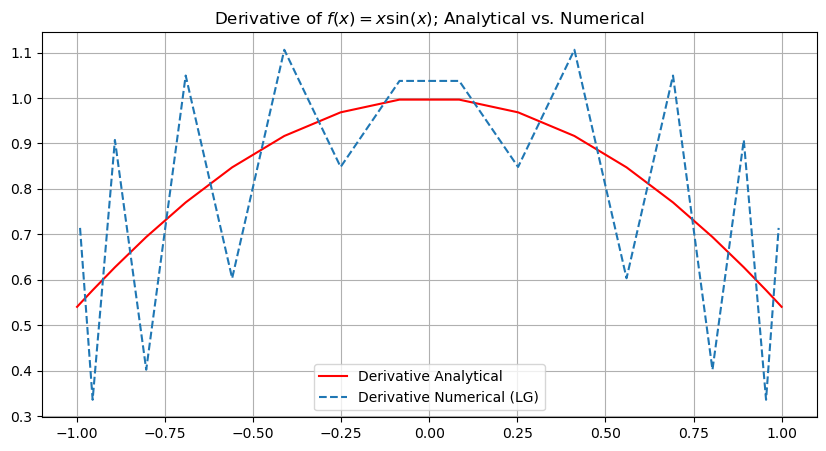

Maximum error: 0.004769757712245246


In [223]:
k = 1
#n = gl_collocation.compute_nodes()

plt.figure(figsize=(10, 5))
plt.plot(nodes, df(nodes), color='red', label=f'Derivative Analytical')
plt.plot(nodes[k:-k], dy_dt[k:-k], '--', label=f'Derivative Numerical (LG)')
plt.title('Derivative of $f(x) = x \sin(x)$; Analytical vs. Numerical')
plt.grid()
plt.legend()
plt.show();

# error = np.mean((df(nodes) - dy_dt)**2)
print("Maximum error:", np.max(error))

----

In [198]:
gl_collocation = Collocation(32, 0, 6, 'gauss_legendre')

nodes = gl_collocation.compute_nodes()
D = gl_collocation.compute_derivative_matrix()

dy_dt = []
nodes_filtered = []

for i in range(len(nodes)):
    if i % 2 == 0:
        nodes_filtered.append(nodes[i])
        dy_dt.append(D[i] @ f(nodes))

In [199]:
# this approach involves re-computing the nodes and derivative matrix
gl_collocation_16 = Collocation(16, 0, 6, 'gauss_legendre')

nodes_16 = gl_collocation_16.compute_nodes()
D_16 = gl_collocation_16.compute_derivative_matrix()

dy_dt_16 = []
nodes_filtered_16 = []
for i in range(len(nodes_16)):
    nodes_filtered_16.append(nodes_16[i])
    dy_dt_16.append(D_16[i] @ f(nodes_16))

In [200]:
n = gl_collocation.compute_nodes()

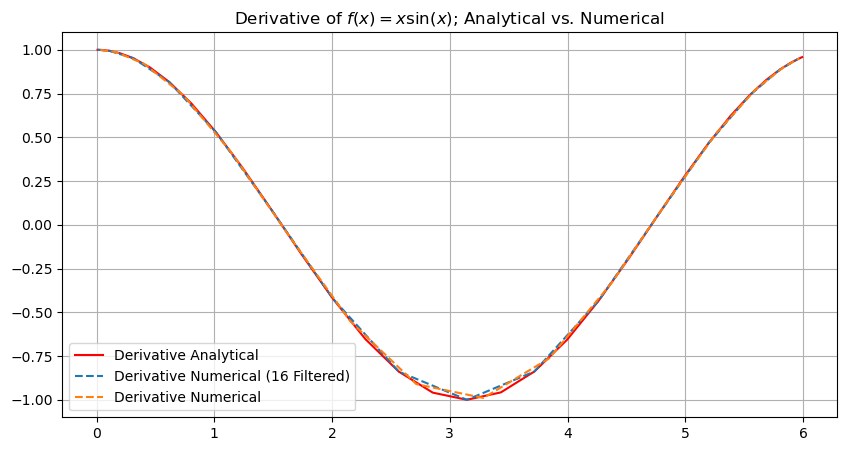

Maximum error: 0.004769757712245246


In [201]:
plt.figure(figsize=(10, 5))
plt.plot(n, df(n), color='red', label=f'Derivative Analytical')
plt.plot(nodes_filtered, dy_dt, '--', label=f'Derivative Numerical (16 Filtered)')
plt.plot(nodes_16, dy_dt_16, '--',label=f'Derivative Numerical')
plt.title('Derivative of $f(x) = x \sin(x)$; Analytical vs. Numerical')
plt.grid()
plt.legend()
plt.show();

# error = np.mean((df(nodes) - dy_dt)**2)

print("Maximum error:", np.max(error))